# **Scalable Variational Quantum Algorithm utilizing QFT for Poisson Equation**

In [6]:

import random
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
from qiskit_ionq import IonQProvider

from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import Isometry


from functions import *
from Laplacian1D import *
from derivatives import *
from numerator import *

### **Initialize Simulator and Hardware Backend**

In [40]:
import os

# IonQ Simulator
os.environ['IONQ_API_KEY'] = 'BU5YwsZpbahvhbxSOEc9qMCvyCqhmxq8'
my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

QiskitRuntimeService.save_account(channel='ibm_quantum', instance = 'yonsei-dedicated/internal/ybscandid', token = '015ed0dbd6ac8e20932a46e1a870ba6a9580beac9e4167d6728fc7b1752c22e6b1dead1ae6c723abc06fdc60c06753d543774a14bafa2ff8f17252673c08f33f', overwrite = True)
hardware_backend = QiskitRuntimeService().backend('ibm_yonsei')

ApiException: Error: Provided API key could not be found., Status code: 400

### **Set Parameters & Source Function**

In [7]:
grid_num = 256
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

### **Initialize Sampler**

In [ ]:
options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Create Ansatz**

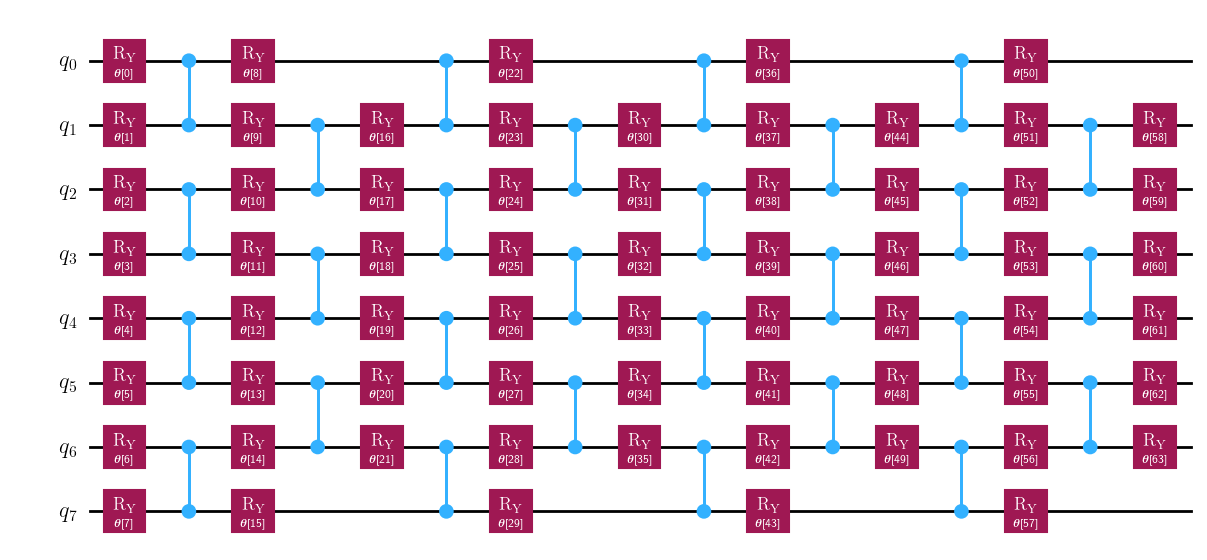

In [34]:
num_qubits = int(np.log2(grid_num))
num_qubits1D = int(num_qubits / 2)
ansatz_depth = 4
param_num = num_qubits + ansatz_depth * (2 * num_qubits - 2)

parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

psi_param_circuit = create_parameterized_ansatz(num_qubits, ansatz_depth, parameters)
psi_param_gate = psi_param_circuit.to_gate(label = r'$\left|\psi(\boldsymbol{\theta})\right\rangle$')
psi_param_circuit.draw('mpl', fold = -1)

### **Derive Analytic Solution**

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
C:\Users\MPMC\AppData\Local\Temp\ipykernel_924\2571421263.py:68: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Exact electric potential on $16\\times16\\,\mathrm{nm}^2$ domain', fontsize=14)


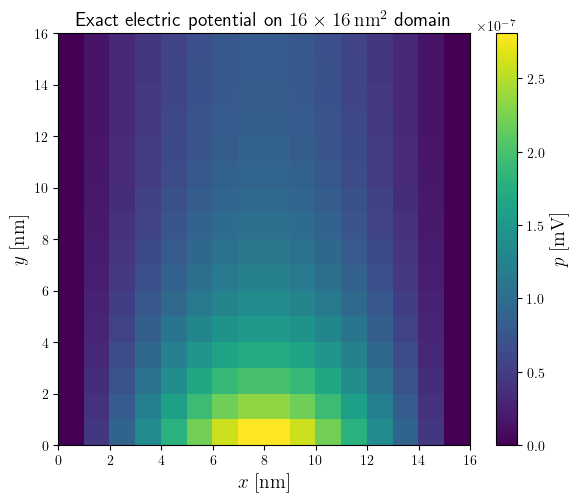

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---- physical parameters ----
L      = 16e-9           # 16 nm [m]
alpha1 = 1.81e-5         # uniform forcing [V]
alpha0 = 0.5             # line-source amplitude [V]

# ---- helper for Fourier coefficients C_n ----
def C_n(n):
    return (np.cos(3.0*n*np.pi/8.0) - np.cos(5.0*n*np.pi/8.0)) / (n*np.pi)

def p_series(x, y, Nmax=200, Mmax=200):
    """
    Exact series solution truncated at (Nmax, Mmax).
    x, y : numpy arrays (physical metres, 0 <= x,y <= L)
    """
    xi  = x / L
    eta = y / L

    # --- P2 : uniform forcing part (odd n only) ---
    n = np.arange(1, Nmax+1, 2)                  # odd indices
    sin_nxi = np.sin(np.pi*np.outer(xi, n))      # shape (Nx, n)
    P2 = (-8*L**2*alpha1/np.pi**3) * (sin_nxi / n**3).sum(axis=1)

    # --- P1 : line source part ---
    n = np.arange(1, Nmax+1)                     # 1..Nmax
    Cn = C_n(n)                                  # (N,)
    sin_nxi = np.sin(np.pi*np.outer(xi, n))      # (Nx, N)

    # m = 0 term
    P1 = (2*L*alpha0/np.pi**3) * (Cn / n**3) * sin_nxi
    P1 = P1.sum(axis=1)                          # shape (Nx,)

    # m >= 1 terms
    m = np.arange(1, Mmax+1)                     # 1..Mmax
    cos_meta = np.cos(np.pi*np.outer(eta, m))    # (Ny, M)

    # denominator matrix (N,M)
    denom = n[:,None]**2 + m[None,:]**2          # broadcasting
    coeff = (2*L*alpha0/np.pi**3) * (Cn[:,None] / (n[:,None]*denom))

    # triple product → P1 contribution
    #   sum_n sum_m coeff(n,m) * sin(nπξ) * cos(mπη)
    term_nm = np.tensordot(sin_nxi, coeff, axes=([1],[0])) # (Nx, M)
    P1 += (term_nm * cos_meta).sum(axis=1)                  # (Nx,)

    return P1 + P2

# ---- build grid & evaluate ----
Nx = Ny = 16
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

P = p_series(X.ravel(), Y.ravel()).reshape(Ny, Nx)

# ---- plot ----
plt.figure(figsize=(6,5))
plt.imshow(P*1e3,            # mV for readability
           origin='lower',
           extent=[0,16,0,16],   # nm
           cmap='viridis')
plt.xlabel(r'$x \;[\mathrm{nm}]$', fontsize=14)
plt.ylabel(r'$y \;[\mathrm{nm}]$', fontsize=14)
cbar = plt.colorbar()
cbar.set_label(r'$p\;[\mathrm{mV}]$', fontsize=14)
plt.title('Exact electric potential on $16\\times16\\,\mathrm{nm}^2$ domain', fontsize=14)
plt.tight_layout()
plt.show()


P_1d = P.flatten()
analytic_psi = P_1d / np.linalg.norm(P_1d)

### **Set Source Function**

In [25]:
alpha_0 = 0.5
alpha_1 = 1.81 * 10**(-5)
eta = np.arctan(np.sqrt(2)**(num_qubits1D + 2) * alpha_1 / alpha_0)

b_0 = np.sqrt(2) * np.array([0,0,0,1,1,0,0,0])
b_0 = np.kron(b_0, np.sqrt(0.5) * np.array([1,1]))
b_0 = np.kron(b_0, np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))
b_1 = np.ones(grid_num)
b = alpha_0 * b_0 + alpha_1 * b_1

beta_0 = alpha_0 * np.linalg.norm(b_0) / np.linalg.norm(b)
beta_1 = alpha_1 * np.linalg.norm(b_1) / np.linalg.norm(b)

In [27]:
I = np.array([[1,0],
             [0,1]], dtype = complex)

X = np.array([[0,1],
             [1,0]], dtype = complex)
classical_CNOT = np.array([[1,0,0,0],
                          [0,1,0,0],
                          [0,0,0,1],
                          [0,0,1,0]], dtype=complex)
def CNOT_matrix(num_qubits, control_index):
    if control_index != 0:
        matrix = np.array([[1,0],[0,1]], dtype = complex)
    else:
        matrix = 1
    for i in range (1, control_index):
        matrix = np.kron(matrix, I)
    matrix = np.kron(matrix, classical_CNOT)
    for i in range (control_index+2, num_qubits):
        matrix = np.kron(matrix, I)
    return matrix
def classical_RZGate(theta):
    return np.array([[np.exp(-1j * theta/2), 0],
                    [0, np.exp(1j * theta/2)]], dtype = complex)

def classical_RYGate(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)],
                    [np.sin(theta/2), np.cos(theta/2)]], dtype = complex)

def classical_RYGate_nqubits(params, num_qubits):
    RYGate = classical_RYGate(params[0])
    for qubit_num in range (num_qubits-1):
        RYGate = np.kron(RYGate, classical_RYGate(params[qubit_num+1]))
    return RYGate
        
def classical_RZGate_nqubits(params, num_qubits):
    RZGate = classical_RZGate(params[0])
    for qubit_num in range (num_qubits-1):
        RZGate = np.kron(RZGate, classical_RZGate(params[qubit_num+1]))
    return RZGate
def make_classical_psi(params):
    
    # Make the first layer of RY & RZ
    psi_list = []
    for qubit in range(0,num_qubits):
        psi = np.array([1,0], dtype = complex)
        psi = classical_RYGate(params[qubit]) @ psi.T
        psi_list.append(psi)
    psi = psi_list[0]
    for psis in psi_list[1:]:
        psi = np.kron(psi, psis)
    # First CNOT barrier
    for qubit in range (0, num_qubits - 1):
        psi = CNOT_matrix(num_qubits, qubit) @ psi
    
    for depth in range (1, ansatz_depth):
        psi = classical_RYGate_nqubits(params = [params[i] for i in range ((num_qubits)*depth , (num_qubits)*depth + num_qubits)], num_qubits=num_qubits) @ psi
        for qubit in range (0, num_qubits-1):
           psi = CNOT_matrix(num_qubits, qubit) @ psi
    return psi

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\scipy\optimize\_optimize.py:3581: ComplexWarning: Casting complex values to real discards the imaginary part
  direc[-1] = direc1


Optimization terminated successfully.
         Current function value: -1043.008549-0.000000j
         Iterations: 13
         Function evaluations: 4742


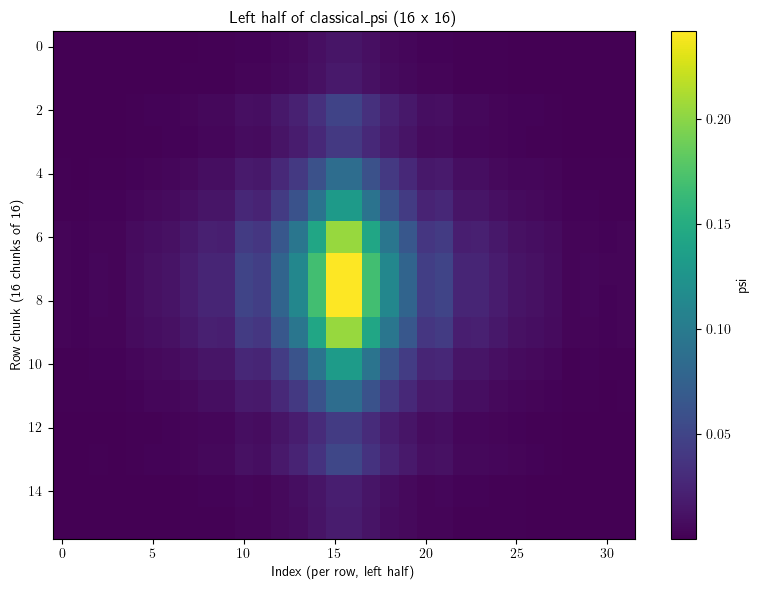

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


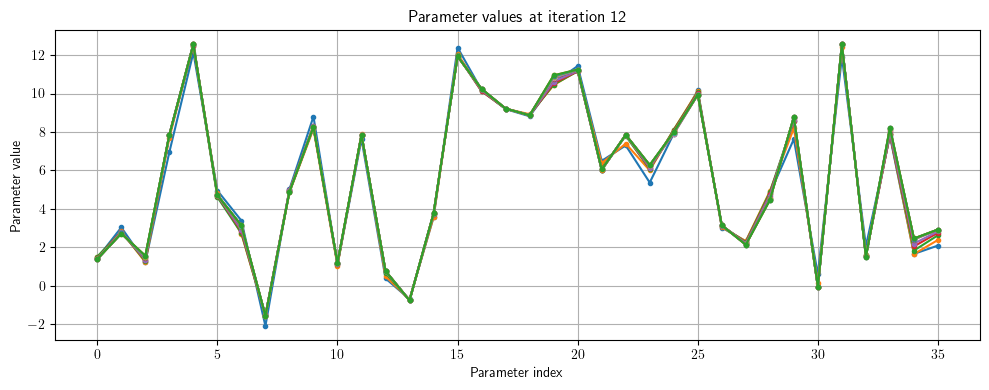

In [20]:
alpha_0 = 0.5
alpha_1 = 1.81 * 10**(-5)
eta = np.arctan(np.sqrt(2)**(num_qubits1D + 2) * alpha_1 / alpha_0)
b_1 = np.ones(grid_num * 2)

b_0 = np.zeros(grid_num * 2)
for i in range (int(one_dim_grid_num / 4)):
    first_index_1 = (3 * one_dim_grid_num ** 2 / 4 + one_dim_grid_num - 1)
    first_index_2 = 3 * one_dim_grid_num ** 2 / 4 + one_dim_grid_num
    
    b_0[int(first_index_1 + 2 * one_dim_grid_num * i)] = 1
    b_0[int(first_index_2 + 2 * one_dim_grid_num * i)] = 1
    
    
b = alpha_0 * b_0 + alpha_1 * b_1

param_num = ansatz_depth * num_qubits

def cost_function_classical(params):
    classical_psi = make_classical_psi(params)
    num = np.inner(b, classical_psi)**2
    x_gridnum = one_dim_grid_num * 2
    y_gridnum = one_dim_grid_num
    A_x = laplacian_matrix(x_gridnum, "Periodic")
    A_x = np.kron(np.eye(y_gridnum), A_x)
    A_y =laplacian_matrix(y_gridnum, "Dirichlet")
    A_y = np.kron(A_y, np.eye(x_gridnum))
    
    denom = classical_psi @ (A_x + A_y) @ classical_psi
    # print(num / denom)
    return 256 * num  / denom

from scipy.optimize import minimize
from scipy.optimize import Bounds

initial_params = np.random.rand(param_num) * 4 * np.pi

params_history = []
cost_history = []

# callback 함수 정의
def save_params_with_cost(xk):
    params_copy = np.copy(xk)
    params_history.append(params_copy)
    cost = cost_function_classical(params_copy)
    cost_history.append(cost)

result = minimize(
    cost_function_classical,
    initial_params,
    method='Powell',
    callback=save_params_with_cost,  # 콜백 함수 등록
    options={
        'disp': True,
        'maxiter': 1000000,
        'maxfev': 10000000
    }
)
optimal_params_simulator = np.array(result.x)


classical_psi = make_classical_psi(optimal_params_simulator)
psi_2d = np.reshape(classical_psi, (16, 32))

psi_left_half = psi_2d#[:, 16:]

# 그림 생성
plt.figure(figsize=(8,6))  # 절반이므로 가로 크기도 줄임

plt.imshow(np.abs(psi_left_half), cmap='viridis', aspect='auto')
plt.colorbar(label='psi')
plt.xlabel('Index (per row, left half)')
plt.ylabel('Row chunk (16 chunks of 16)')
plt.title('Left half of classical_psi (16 x 16)')

plt.tight_layout()
plt.show()

def plot_param_evolution_every_10(params_history):
    params_array = np.array(params_history)
    total_iters = len(params_array)
    
    # 10개 단위로 시각화
    plt.figure(figsize=(10, 4))
    for i in range(0, total_iters):
        
        plt.plot(params_array[i], marker='o', linestyle='-', markersize=3)
        plt.title(f'Parameter values at iteration {i}')
        plt.xlabel('Parameter index')
        plt.ylabel('Parameter value')
        plt.grid(True)
        plt.tight_layout()
    plt.show()

plot_param_evolution_every_10(params_history)
np.savetxt("params5.csv", params_history, delimiter=",")

C:\Users\MPMC\AppData\Local\Temp\ipykernel_5004\4046627101.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  param_array = df.applymap(lambda x: complex(x)).values


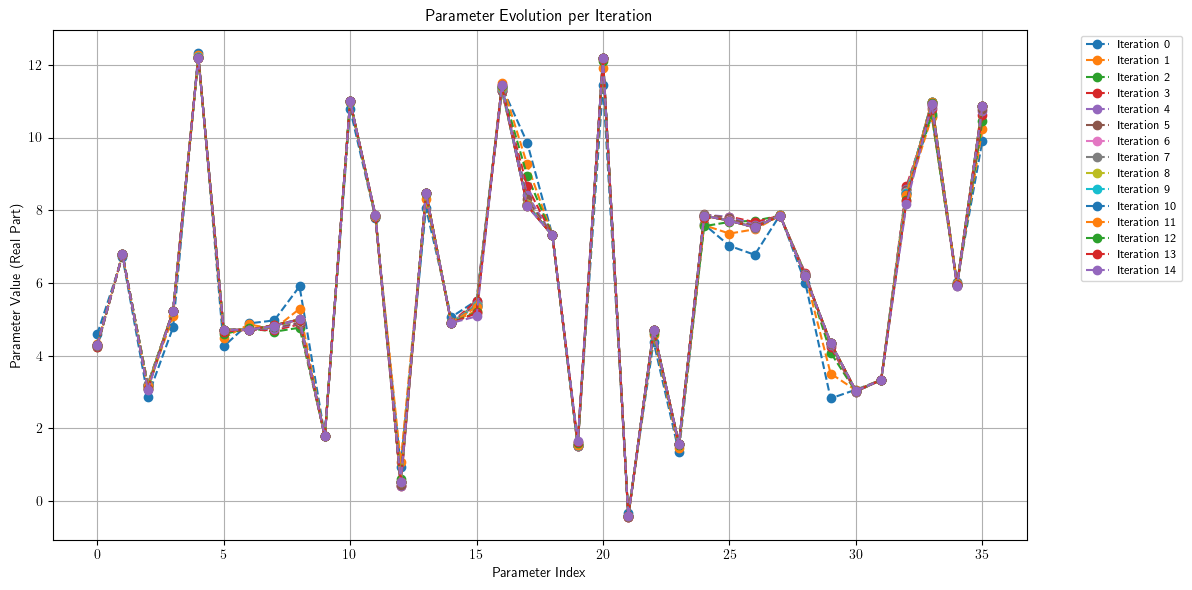

C:\Users\MPMC\AppData\Local\Temp\ipykernel_5004\4046627101.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  param_array = df.applymap(lambda x: complex(x)).values


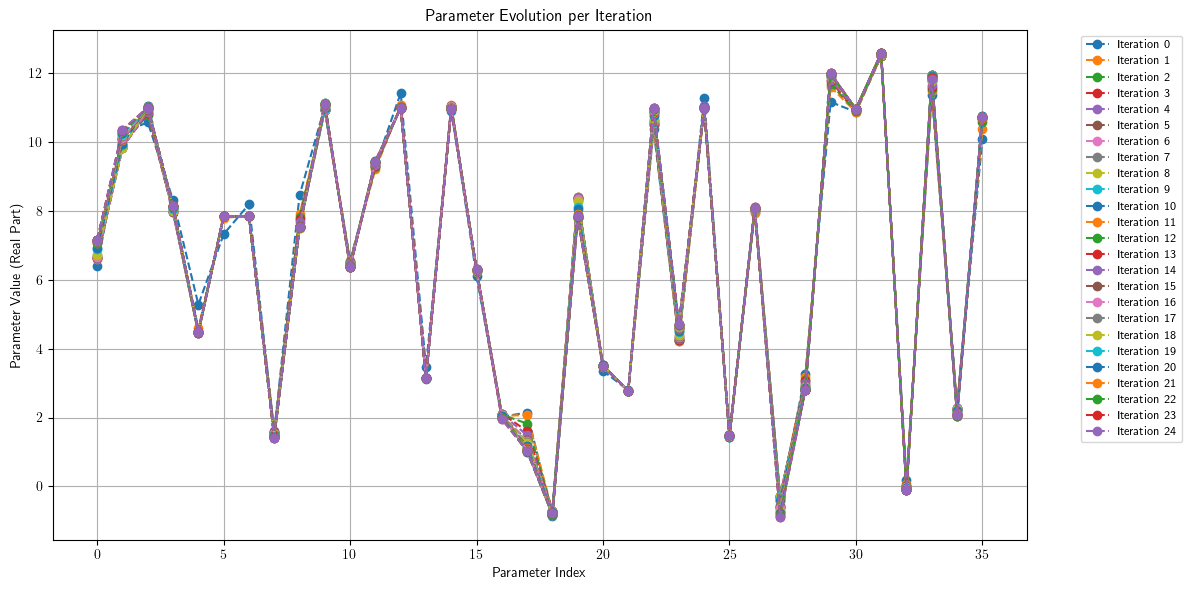

C:\Users\MPMC\AppData\Local\Temp\ipykernel_5004\4046627101.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  param_array = df.applymap(lambda x: complex(x)).values


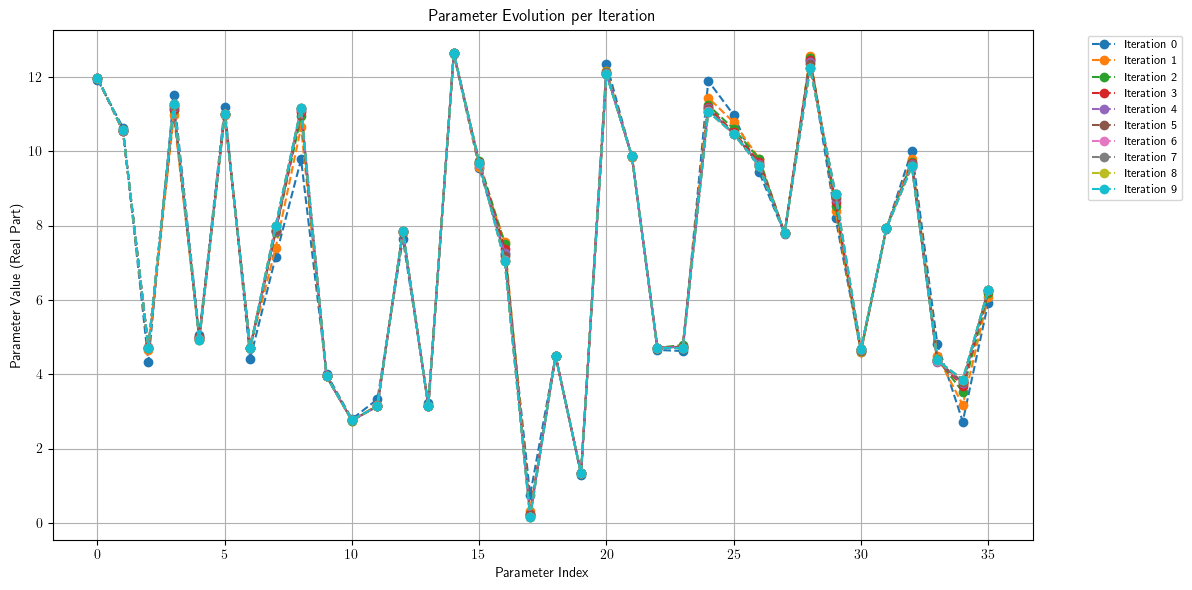

C:\Users\MPMC\AppData\Local\Temp\ipykernel_5004\4046627101.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  param_array = df.applymap(lambda x: complex(x)).values


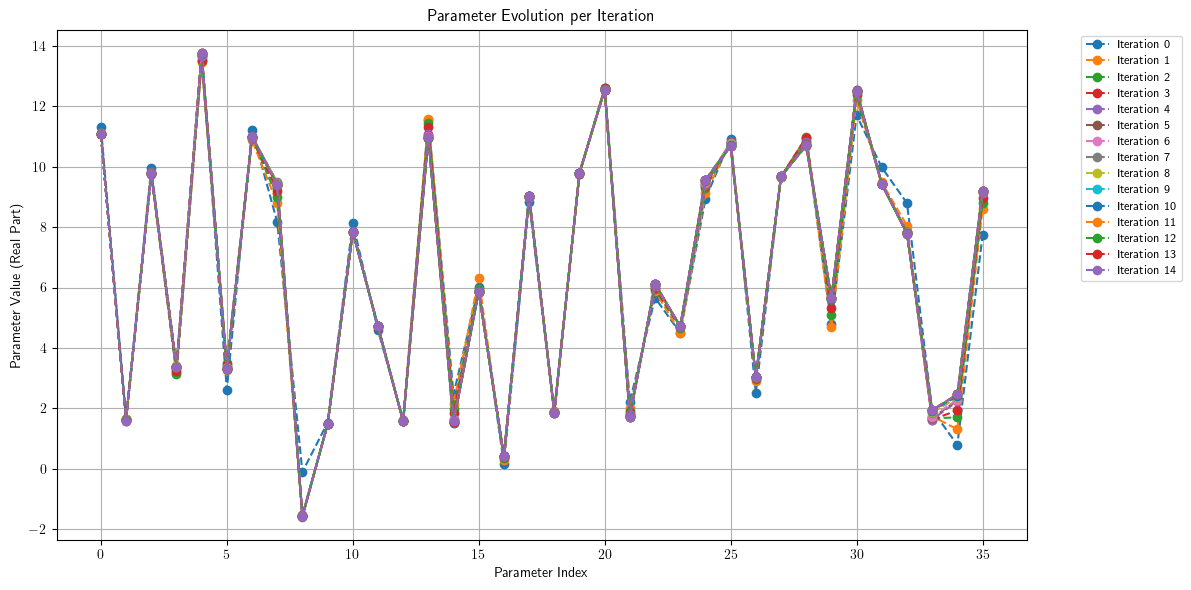

C:\Users\MPMC\AppData\Local\Temp\ipykernel_5004\4046627101.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  param_array = df.applymap(lambda x: complex(x)).values


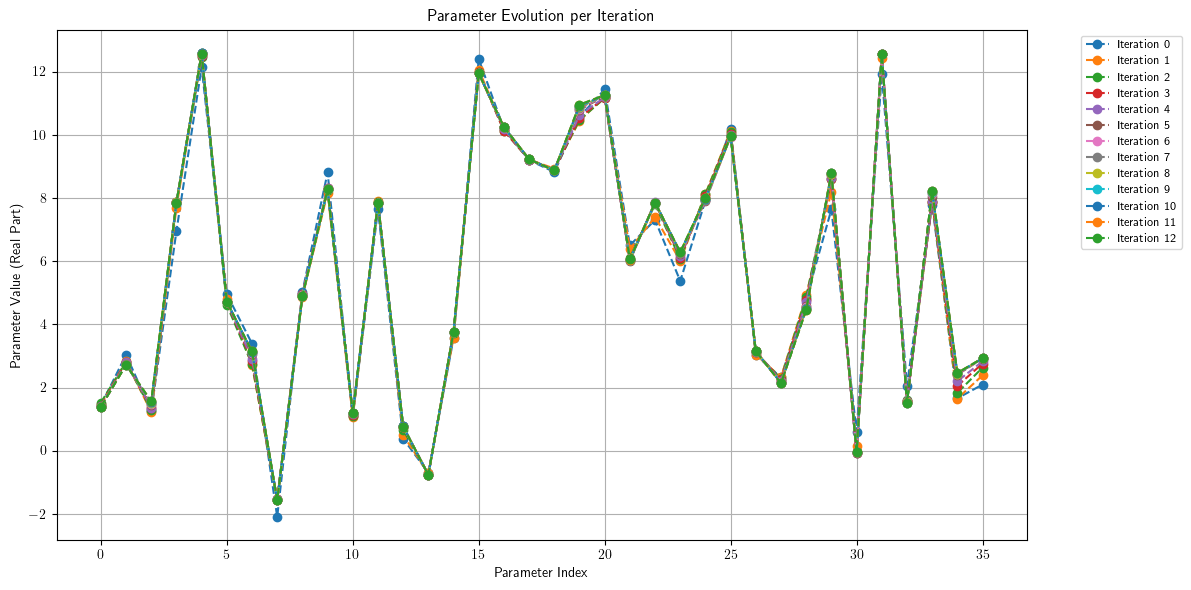

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
def plot_params(file_path):
    df = pd.read_csv(file_path, header=None)

    # Convert all entries to complex numbers
    param_array = df.applymap(lambda x: complex(x)).values

    # Plot each row as a line
    plt.figure(figsize=(12, 6))
    for i, row in enumerate(param_array):
        plt.plot(range(len(row)), row.real, label=f'Iteration {i}', linestyle = '--', marker = 'o')

    plt.xlabel('Parameter Index')
    plt.ylabel('Parameter Value (Real Part)')
    plt.title('Parameter Evolution per Iteration')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=1)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
plot_params("params1.csv")
plot_params("params2.csv")
plot_params("params3.csv")
plot_params("params4.csv")
plot_params("params5.csv")

Optimization terminated successfully.
         Current function value: -667.706631-0.000000j
         Iterations: 23
         Function evaluations: 15758


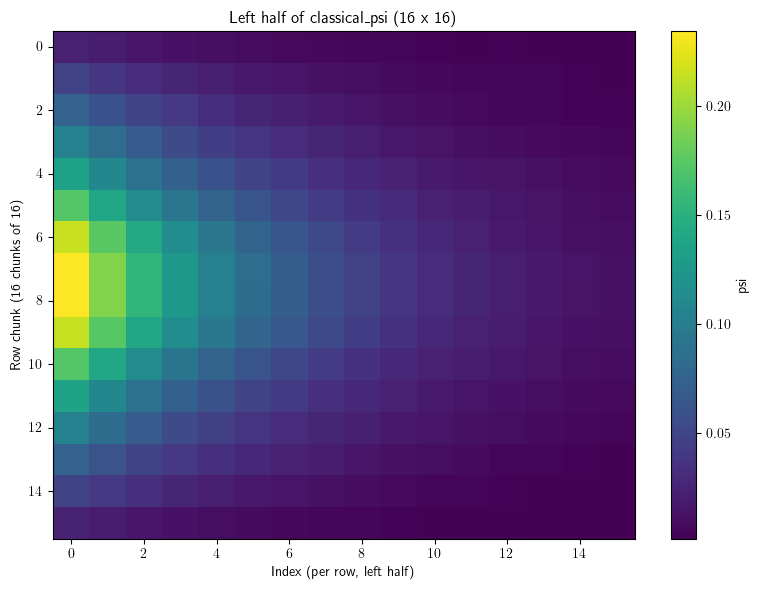

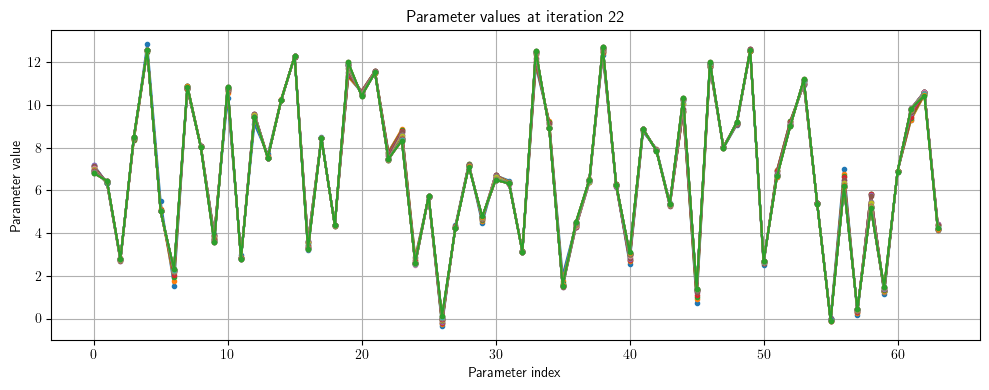

In [39]:
# ansatz_depth = 5
# param_num = ansatz_depth * num_qubits
from functions import *
def cost_function_classical(params):
    alpha_0 = 0.5
    alpha_1 = 1.81 * 10**(-5)
    eta = np.arctan(np.sqrt(2)**(num_qubits1D + 2) * alpha_1 / alpha_0)

    b_0 = np.sqrt(2) * np.array([0,0,0,1,1,0,0,0])
    b_0 = np.kron(b_0, np.sqrt(0.5) * np.array([1,1]))
    b_0 = np.kron(b_0, np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))
    b_1 = np.ones(grid_num)
    b = alpha_0 * b_0 + alpha_1 * b_1

    classical_psi = make_classical_psi(num_qubits, ansatz_depth, params)
    num = np.inner(b, classical_psi)**2
    x_gridnum = one_dim_grid_num
    y_gridnum = one_dim_grid_num
    A_x = laplacian_matrix(x_gridnum, "Neumann")
    A_x = np.kron(np.eye(y_gridnum), A_x)
    A_y =laplacian_matrix(y_gridnum, "Dirichlet")
    A_y = np.kron(A_y, np.eye(x_gridnum))
    
    denom = classical_psi @ (A_x + A_y) @ classical_psi
    # print(num / denom)
    return 256 * num  / denom

from scipy.optimize import minimize
from scipy.optimize import Bounds

initial_params = np.random.rand(param_num) * 4 * np.pi

params_history = []
cost_history = []

# callback 함수 정의
def save_params_with_cost(xk):
    params_copy = np.copy(xk)
    params_history.append(params_copy)
    cost = cost_function_classical(params_copy)
    cost_history.append(cost)

result = minimize(
    cost_function_classical,
    initial_params,
    method='Powell',
    callback=save_params_with_cost,  # 콜백 함수 등록
    options={
        'disp': True,
        'maxiter': 1000000,
        'maxfev': 10000000
    }
)
optimal_params_simulator = np.array(result.x)


classical_psi = make_classical_psi(num_qubits, ansatz_depth, optimal_params_simulator)
psi_2d = np.reshape(classical_psi, (16, 16))
plt.figure(figsize=(8,6))  # 절반이므로 가로 크기도 줄임

plt.imshow(np.abs(psi_2d), cmap='viridis', aspect='auto')
plt.colorbar(label='psi')
plt.xlabel('Index (per row, left half)')
plt.ylabel('Row chunk (16 chunks of 16)')
plt.title('Left half of classical_psi (16 x 16)')

plt.tight_layout()
plt.show()

def plot_param_evolution_every_10(params_history):
    params_array = np.array(params_history)
    total_iters = len(params_array)
    
    # 10개 단위로 시각화
    plt.figure(figsize=(10, 4))
    for i in range(0, total_iters):
        
        plt.plot(params_array[i], marker='o', linestyle='-', markersize=3)
        plt.title(f'Parameter values at iteration {i}')
        plt.xlabel('Parameter index')
        plt.ylabel('Parameter value')
        plt.grid(True)
        plt.tight_layout()
    plt.show()

plot_param_evolution_every_10(params_history)
np.savetxt("choi_params5.csv", params_history, delimiter=",")

### **Design Cost Function (Simulator)**

In [13]:
import numerator
import Laplacian2D.Laplacian2D_simulator
import Laplacian2D.Laplacian2D_hardware

def cost_function_simulator(params):
    
    num = numerator.fpsi_Choi_simulator(params, parameters, psi_param_gate, eta, num_qubits, simulator_backend, num_shots)
    num *= 2 * (beta_0 ** 2 + beta_1 ** 2)
    
    denom_y = Laplacian2D.Laplacian2D_simulator.laplacian_evs_2D_simulator_neumann(params, parameters, psi_param_gate, num_qubits, simulator_backend, num_shots, 'y')
    denom_x = Laplacian2D.Laplacian2D_simulator.laplacian_evs_2D_simulator_periodic(params, parameters, psi_param_gate, num_qubits, simulator_backend, num_shots, 'x')
    denom = (denom_x + denom_y) * grid_num * grid_num
    
    cost_function = 0.5 * num / denom
    
    return cost_function

trace_distances = []
def callback_fn(params):
    classical_psi = make_classical_psi(num_qubits, ansatz_depth, params, reverse=True)
    trace_distance = 1 - np.inner(classical_psi, analytic_psi)**2
    trace_distance = np.sqrt(trace_distance)
    trace_distances.append(trace_distance)
    print(f"[Callback] Trace Distance: {trace_distance}")

### **Conduct Optimization (Gradient-Free)**

In [14]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

initial_params = np.random.rand(param_num) * np.pi
bounds = Bounds([0]*param_num, [np.pi]*param_num)

result = minimize(
    cost_function_simulator,
    initial_params,
    method='Powell',
    bounds=bounds,
    callback=callback_fn,
    options={
        'disp': True,
        'maxiter': 1000000,
        'maxfev': 10000000
    }
)


c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying submit_job 4 more time(s) after IonQRetriableError('No error details provided.')
  warnings.warn(


[Callback] Trace Distance: (0.9186662502809548+0j)


c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying get_results after IonQRetriableError('Unknown error')
  warnings.warn(
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying get_results after IonQRetriableError('Unknown error')
  warnings.warn(
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying retrieve_job after IonQRetriableError('Unknown error')
  warnings.warn(
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\qiskit_ionq\helpers.py:664: UserWarning: Retrying submit_job 4 more time(s) after IonQRetriableError('No error details provided.')
  warnings.warn(


[Callback] Trace Distance: (0.8419824054787202+0j)


SSLError: HTTPSConnectionPool(host='api.ionq.co', port=443): Max retries exceeded with url: /v0.3/jobs (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1028)')))

c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MPMC\anaconda3\envs\cwq\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


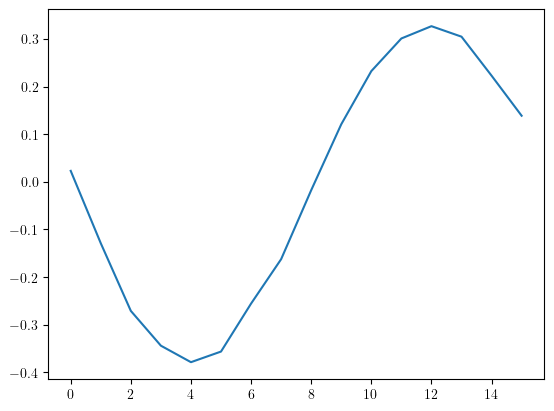

In [ ]:
optimal_params_simulator = np.array(result.x)
classical_psi = make_classical_psi(num_qubits, ansatz_depth, optimal_params_simulator, reverse = True)

plt.figure(figsize = (7,7))
plt.plot(classical_psi)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- physical parameters ----
L      = 16e-9           # 16 nm [m]
alpha1 = 1.81e-5         # uniform forcing [V]
alpha0 = 0.5             # line-source amplitude [V]

# ---- helper for Fourier coefficients C_n ----
def C_n(n):
    return (np.cos(3.0*n*np.pi/8.0) - np.cos(5.0*n*np.pi/8.0)) / (n*np.pi)

def p_series(x, y, Nmax=200, Mmax=200):
    """
    Exact series solution truncated at (Nmax, Mmax).
    x, y : numpy arrays (physical metres, 0 <= x,y <= L)
    """
    xi  = x / L
    eta = y / L

    # --- P2 : uniform forcing part (odd n only) ---
    n = np.arange(1, Nmax+1, 2)                  # odd indices
    sin_nxi = np.sin(np.pi*np.outer(xi, n))      # shape (Nx, n)
    P2 = (-8*L**2*alpha1/np.pi**3) * (sin_nxi / n**3).sum(axis=1)

    # --- P1 : line source part ---
    n = np.arange(1, Nmax+1)                     # 1..Nmax
    Cn = C_n(n)                                  # (N,)
    sin_nxi = np.sin(np.pi*np.outer(xi, n))      # (Nx, N)

    # m = 0 term
    P1 = (2*L*alpha0/np.pi**3) * (Cn / n**3) * sin_nxi
    P1 = P1.sum(axis=1)                          # shape (Nx,)

    # m >= 1 terms
    m = np.arange(1, Mmax+1)                     # 1..Mmax
    cos_meta = np.cos(np.pi*np.outer(eta, m))    # (Ny, M)

    # denominator matrix (N,M)
    denom = n[:,None]**2 + m[None,:]**2          # broadcasting
    coeff = (2*L*alpha0/np.pi**3) * (Cn[:,None] / (n[:,None]*denom))

    # triple product → P1 contribution
    #   sum_n sum_m coeff(n,m) * sin(nπξ) * cos(mπη)
    term_nm = np.tensordot(sin_nxi, coeff, axes=([1],[0])) # (Nx, M)
    P1 += (term_nm * cos_meta).sum(axis=1)                  # (Nx,)

    return P1 + P2

# ---- build grid & evaluate ----
Nx = Ny = 16
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

P = p_series(X.ravel(), Y.ravel()).reshape(Ny, Nx)

# ---- plot ----
plt.figure(figsize=(6,5))
plt.imshow(P*1e3,            # mV for readability
           origin='lower',
           extent=[0,16,0,16],   # nm
           cmap='viridis')
plt.xlabel(r'$x \;[\mathrm{nm}]$', fontsize=14)
plt.ylabel(r'$y \;[\mathrm{nm}]$', fontsize=14)
cbar = plt.colorbar()
cbar.set_label(r'$p\;[\mathrm{mV}]$', fontsize=14)
plt.title('Exact electric potential on $16\\times16\\,\mathrm{nm}^2$ domain', fontsize=14)
plt.tight_layout()
plt.show()